In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def capture_image(filename="captured_face.jpg"):
    """ Capture an image from the webcam and save it """
    cap = cv2.VideoCapture(0)
    print("Press 's' to capture the image...")

    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        cv2.imshow("Capture Image", frame)

        if cv2.waitKey(1) & 0xFF == ord('s'):  # Press 's' to save
            cv2.imwrite(filename, frame)
            print("Image saved successfully!")
            break

    cap.release()
    cv2.destroyAllWindows()
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Step 1: Capture the reference image
reference_image = capture_image()


Press 's' to capture the image...
Image saved successfully!


In [8]:
from sklearn.decomposition import PCA
import numpy as np
def extract_features(image, method="SIFT"):
    """ Extract features using SIFT, ORB, or BRIEF and return a flattened feature vector """
    if method == "SIFT":
        extractor = cv2.SIFT_create()
    elif method == "ORB":
        extractor = cv2.ORB_create()
    elif method == "BRIEF":
        fast = cv2.FastFeatureDetector_create()
        extractor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        keypoints = fast.detect(image, None)
        keypoints, descriptors = extractor.compute(image, keypoints)
        
        # return keypoints, descriptors
    else:
        raise ValueError("Unsupported feature extraction method")
    
    if method != "BRIEF":
        keypoints, descriptors = extractor.detectAndCompute(image, None)
        
    # visualizing the keypoints on the image and the selected descriptors
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.show()
    plt.axis("off")
    
    
    

    if descriptors is not None:
        # Ensure PCA components are valid
        n_samples, n_features = descriptors.shape
        n_components = min(n_samples, n_features, 80)  # Dynamically choose max 20 features

        if n_components > 1:
            pca = PCA(n_components=n_components)
            descriptors = pca.fit_transform(descriptors)
        
        # Take mean of descriptors to form a single feature vector
        feature_vector = np.mean(descriptors, axis=0) if descriptors is not None else np.zeros(n_components)

        return keypoints, feature_vector
    else:
        return keypoints, None


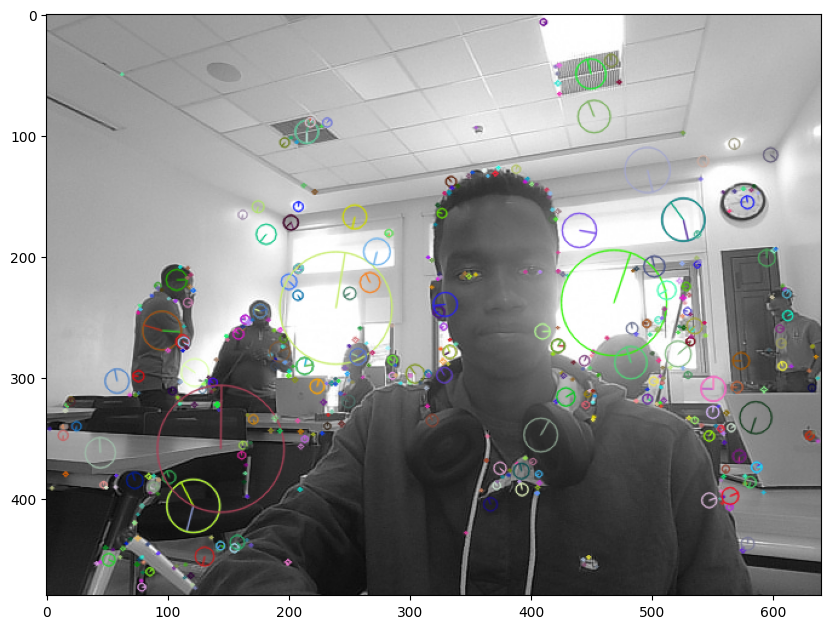

Number of keypoints detected: 559


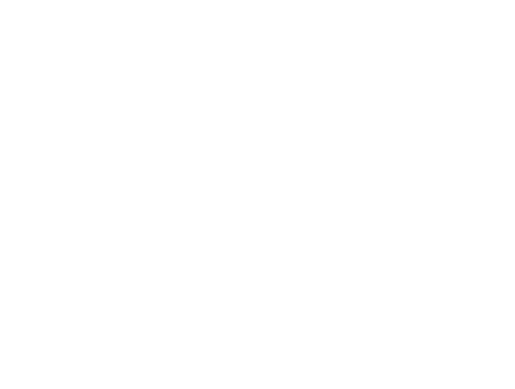

In [9]:
# Step 2: Extract features from the captured image
method = "SIFT"  # Change to "ORB" or "BRIEF" to test
reference_keypoints, reference_features = extract_features(reference_image, method)
print("Number of keypoints detected:", len(reference_keypoints))


In [41]:
# Dictionary to store features
stored_features = {
    "method": method,
    "features": reference_features
}

print(f"Stored feature vector using {method}: {reference_features.shape} dimensions")


Stored feature vector using SIFT: (80,) dimensions


In [42]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity

def match_features(new_features, stored_features, method="euclidean"):
    """ Compare features using Euclidean Distance or Cosine Similarity """
    if method == "euclidean":
        distance = euclidean(new_features, stored_features)
        return distance  # Lower value means closer match
    elif method == "cosine":
        similarity = cosine_similarity([new_features], [stored_features])[0][0]
        return similarity  # Higher value means closer match
    else:
        raise ValueError("Unsupported matching method")

# Capture a new image for comparison
# comparison_image = capture_image(filename="comparison_face.jpg")
comparison_image = cv2.imread("comparison_face.jpg")

# Extract features from the new image
comparison_keypoints, comparison_features = extract_features(comparison_image, method)
print("Number of keypoints detected:", len(comparison_keypoints))

# Compare using Euclidean Distance
euclidean_distance = match_features(comparison_features, stored_features["features"], method="euclidean")
print(f"Euclidean Distance: {euclidean_distance}")

# Compare using Cosine Similarity
cosine_score = match_features(comparison_features, stored_features["features"], method="cosine")
print(f"Cosine Similarity Score: {cosine_score}")


Number of keypoints detected: 132
Euclidean Distance: 1.5197741959127598e-05
Cosine Similarity Score: 0.2490941882133484
